<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#To-load-the-data" data-toc-modified-id="To-load-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>To load the data</a></span></li><li><span><a href="#Load-the-strong-annotation-and-the-ground-thruth" data-toc-modified-id="Load-the-strong-annotation-and-the-ground-thruth-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the strong annotation and the ground thruth</a></span></li><li><span><a href="#Prune-using-ground-truth-(ORACLE)" data-toc-modified-id="Prune-using-ground-truth-(ORACLE)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prune using ground truth (ORACLE)</a></span></li><li><span><a href="#Display-function" data-toc-modified-id="Display-function-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Display function</a></span></li><li><span><a href="#Manual" data-toc-modified-id="Manual-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Manual</a></span></li><li><span><a href="#Parametric" data-toc-modified-id="Parametric-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Parametric</a></span><ul class="toc-item"><li><span><a href="#Absolute-Threshold" data-toc-modified-id="Absolute-Threshold-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Absolute Threshold</a></span></li><li><span><a href="#Hysteresis" data-toc-modified-id="Hysteresis-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Hysteresis</a></span></li><li><span><a href="#Derivative" data-toc-modified-id="Derivative-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Derivative</a></span></li></ul></li></ul></div>

# Import

In [22]:
!pip uninstall sed_tool -y

Uninstalling sed-tool-0.0.4:
  Successfully uninstalled sed-tool-0.0.4


In [30]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import os
import pickle
import matplotlib.pyplot as plt
import dcase_util as dcu

from sed_tool.Encoder import Encoder
from sed_tool.optimizers import GenOptimizer, DichotomicOptimizer
from sed_tool.sed_tools import eb_evaluator

import numpy as np

import matplotlib.pyplot as plt

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme="onedork", context="notebook", grid=True)
jtplot.base_context["grid.linewidth"] = 0.2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# To load the data

In [2]:
import numpy as np
import os

class_correspondance = {"Alarm_bell_ringing": 0, "Speech": 1, "Dog": 2, "Cat": 3, "Vacuum_cleaner": 4,
                        "Dishes": 5, "Frying": 6, "Electric_shaver_toothbrush": 7, "Blender": 8, "Running_water": 9}


def load_test_mil():
    filenames = np.load(os.path.join("data", "metadata", "X_test_fn.npy"))
    strong_prediction = np.load(os.path.join("data", "strong_prediction", "mil_cos_test.npy"))
    
    return strong_prediction, filenames

def load_eval_mil():
    filenames = np.load(os.path.join("data", "metadata", "X_eval_fn.npy"))
    strong_prediction = np.load(os.path.join("data", "strong_prediction", "mil_cos_eval.npy"))
    
    return strong_prediction, filenames

def load_test_baseline():
    filenames = np.load(os.path.join("data", "metadata", "X_test_fn.npy"))
    strong_prediction = np.load(os.path.join("data","strong_prediction", "baseline_test.npy"))

    return strong_prediction, filenames

def load_eval_baseline():
    filenames = np.load(os.path.join("data", "metadata", "X_eval_fn.npy"))
    strong_prediction = np.load(os.path.join("data","strong_prediction", "baseline_eval.npy"))

    return strong_prediction, filenames

def load_mil_at_test():
    data = np.load(os.path.join("data", "weak_prediction", "mil_at_test.pkl"))
    weak_prediction = data["all_test_preds"]
    filenames = data["featTestList"]
    
    return weak_prediction, filenames
    
def load_mil_at_eval():
    data = np.load(os.path.join("data", "weak_prediction", "mil_at_eval.pkl"))
    weak_prediction = data["all_eval_preds"]
    filenames = data["featEvalList"]
    
    return weak_prediction, filenames
    

def load_test_ground_truth():
    test_unique_names = np.load(os.path.join("data", "metadata", "X_test_fn.npy"))

    with open(os.path.join("data", "metadata", "test.csv"), "r") as f:
        test_metadata = f.read().splitlines()[1:]
    test_metadata = np.array([info.split("\t") for info in test_metadata])
    test_medata_filenames = np.unique(test_metadata[:, 0])

    y_test = []
    for name in test_medata_filenames:
        # remove  missing files
        if name not in test_unique_names:
            continue

        # create a tag level prediction (aka weak labels)
        output = [0] * 10

        for d in test_metadata:
            if d[0] == name:
                output[class_correspondance[d[-1]]] = 1
        y_test.append(output)
    y_test = np.array(y_test)

    return y_test, test_unique_names

def load_eval_ground_truth():
    eval_unique_names = np.load(os.path.join("data", "metadata", "X_eval_fn.npy"))

    with open(os.path.join("data", "metadata", "eval.csv"), "r") as f:
        eval_metadata = f.read().splitlines()[1:]
    eval_metadata = [info.split("\t") for info in eval_metadata]
    eval_medata_filenames = np.unique([i[0] for i in eval_metadata])

    y_eval = []
    for name in eval_medata_filenames:
        # remove  missing files
        if name not in eval_unique_names:
            continue

        # create a tag level prediction (aka weak labels)
        output = [0] * 10

        for d in eval_metadata:
            if d[0] == name:
                if len(d) == 4:
                    output[class_correspondance[d[-1]]] = 1
        y_eval.append(output)
    y_eval = np.array(y_eval)

    return y_eval, eval_unique_names

def load_test_strong_ground_truth():
    # test ground truth
    with open(os.path.join("data", "metadata", "test.csv"), "r") as f:
        strong_y_true = f.read().splitlines()[1:]
    return strong_y_true

def load_eval_strong_ground_truth():
    # test ground truth
    with open(os.path.join("data", "metadata", "eval.csv"), "r") as f:
        strong_y_true = f.read().splitlines()[1:]
    return strong_y_true

# Load the strong annotation and the ground thruth

In [3]:
test_strong_prediction, test_filenames = load_test_mil()
eval_strong_prediction, eval_filenames = load_eval_mil()
# test_strong_prediction, test_filenames = load_test_baseline()
# eval_strong_prediction, eval_filenames = load_eval_baseline()

# test & eval STRONG PREDICTION ground truth
test_strong_y_true = load_test_strong_ground_truth()
eval_strong_y_true = load_eval_strong_ground_truth()

# test & eval WEAK PREDICTION ground truth ORACLE
test_gt, test_gt_filenames = load_test_ground_truth()
eval_gt, eval_gt_filenames = load_eval_ground_truth()

# test & eval WEAK PREDICTION AT
test_at, test_at_filenames = load_mil_at_test()
eval_at, eval_at_filenames = load_mil_at_eval()

In [4]:
def reorder(to_reorder_data, to_reorder_filenames):
    # create a dict where the key are the filenames and the values the pred
    to_reorder_tmp = dict(zip(to_reorder_filenames, to_reorder_data))
    
    # sort and create a list of tuple (key, pred)
    sort = sorted(to_reorder_tmp.items(), key=lambda kv: kv[0])
    filenames = np.asarray([t[0] for t in sort])
    data = np.asarray([t[1] for t in sort])
    
    return data, filenames

test_at, test_at_filenames = reorder(test_at, test_at_filenames)
eval_at, eval_at_filenames = reorder(eval_at, eval_at_filenames)

test_gt, test_gt_filenames = reorder(test_gt, test_gt_filenames)
eval_gt, eval_gt_filenames = reorder(eval_gt, eval_gt_filenames)

test_strong_prediction, test_filenames = reorder(test_strong_prediction, test_filenames)
eval_strong_prediction, eval_filenames = reorder(eval_strong_prediction, eval_filenames)


In [5]:
test_strong_prediction.mean(), test_strong_prediction.std(), test_strong_prediction.shape

(0.02918718, 0.09151293, (279, 431, 10))

(279, 10)


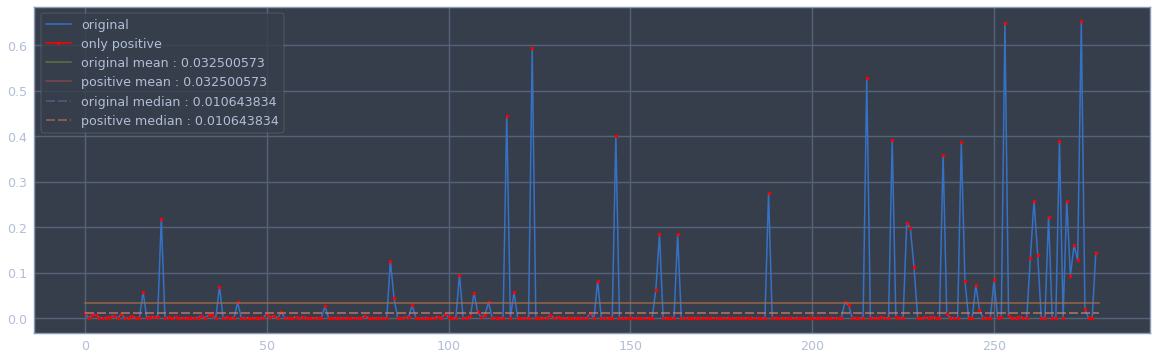

previous : 
[0.03250058 0.04318672 0.00977716 0.0072976  0.01828468 0.00328659
 0.03058764 0.0157005  0.02781211 0.10343817]
(10,)
new : 
[0.03250057 0.04318671 0.00977717 0.0072976  0.01828469 0.00328659
 0.03058764 0.01570049 0.02781212 0.10343817]
(10,)


In [6]:
total_thresholds = []
for clip in test_strong_prediction:
    total_thresholds.append([curve.mean() for curve in clip.T])

total_thresholds = np.array(total_thresholds)
print(total_thresholds.shape)
test = total_thresholds.T[0]

plt.figure(figsize=(20, 6))
plt.plot(test, color="C0", label="original")

count = 0
for i, x in enumerate(test):
    if x != 0:
        if count == 0:
            plt.plot([i], [x], marker=".", color="red", label="only positive")
        else:
            plt.plot([i], [x], marker=".", color="red")
        count += 1

        
orig_mean = test.mean()
new_mean = test[test > 0].mean()
orig_median = test[len(test) // 2]
new_median = test[test > 0][len(test[test > 0]) // 2]

plt.plot([0, 279], [orig_mean, orig_mean], color = "C1", alpha=0.5, label="original mean : %s" % orig_mean)
plt.plot([0, 279], [new_mean, new_mean], color = "C2", alpha=0.5, label="positive mean : %s" % new_mean)
plt.plot([0, 279], [orig_median, orig_median], color = "C3", alpha=0.5, dashes=[6, 2], label="original median : %s" % orig_median)
plt.plot([0, 279], [new_median, new_median], color = "C4", alpha=0.5, dashes=[6, 2], label="positive median : %s" % new_median)
plt.legend()
plt.show()

# removes all mean == 0
means = np.zeros(10)
for i, col in enumerate(total_thresholds.T):
    means[i] = col[col > 0].mean()

print("previous : ")
print(total_thresholds.mean(axis=0))
print(total_thresholds.mean(axis=0).shape)

print("new : ")
print(means)
print(means.shape)

# Prune using ground truth (ORACLE)

In [7]:
# Prune the result of fill the missing curve with 0 segments
def prune_prediction(strong_prediction, cls_prediction):
    """ Prune the strong prediciton by zeroing all classes that are not predicted. """
    pruned_prediction = strong_prediction.copy()
    
    for index in range(len(pruned_prediction)):
        cls_result = cls_prediction[index].copy()
        curves = pruned_prediction[index]

        for i in range(len(cls_result)):
            if cls_result[i] == 0:
                curves[:,i] = 0
                
    return pruned_prediction

In [8]:
# PRUNE USING GROUND TRUTH (AT ORACLE)
eval_strong_prediction = prune_prediction(eval_strong_prediction, eval_gt)
test_strong_prediction = prune_prediction(test_strong_prediction, test_gt)

# # PRUNE USING MODEL AT
# eval_strong_prediction = prune_prediction(eval_strong_prediction, eval_at)
# test_strong_prediction = prune_prediction(test_strong_prediction, test_at)

In [9]:
test_strong_prediction.mean(), test_strong_prediction.std()

(0.014733395, 0.08150168)

# Display function

In [10]:
# monitor one metrics
def monitor_one(results, metric, sort: bool = False):
    out = []
    
    for k in results.keys():
        out.append((k, results[k]["class_wise_average"]["f_measure"][metric]))
        
    if sort:
        out = sorted(out, key=lambda x: x[1])
    
    return np.array(out)

def display_history(metric, hist_metric=None, bins=20):
    x, y = metric[:, 0], metric[:, 1]

    max_y = max(y)
    max_x = list(y).index(max_y)
    print(max_x, max_y)

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.title("f_measure")
    plt.plot(range(len(y)), y, label="f1")
    plt.plot(max_x, max_y, "ro", label="f1:%.2f" % (max_y, ))

    plt.ylabel("f1")
    plt.xlabel("threshold")
    plt.xticks([0, len(x)], [0, len(x)])
    plt.legend()

    plt.subplot(1, 2, 2)
    
    if hist_metric is None:
        plt.hist(list(y), bins=bins)
    else:
        plt.hist(hist_metric, bins=bins)
    plt.show()
    
    return x[list(y).index(max_y)]

# Manual

In [84]:
# TEST
# Create the encoder that will be used
class_list = ['Alarm_bell_ringing', 'Speech', 'Dog', 'Cat', 'Vacuum_cleaner', 'Dishes', 'Frying', 'Electric_shaver_toothbrush', 'Blender', 'Running_water']

encoder = Encoder(
    classes=class_list,
    temporal_precision = 200,  # ms
    clip_length = 10,          # s
    minimal_segment_step = 200 # ms
)

segments = encoder.encode(
    eval_strong_prediction,
    method="threshold",
    threshold=0.025,
    smooth="smoothMovingAvg",
    window_len=19
)
to_evaluate = encoder.parse(segments, eval_filenames)
evaluator = eb_evaluator(eval_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 7543.56 sec
  Evaluated files                   : 880 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 32.54 %
    Precision                       : 34.26 %
    Recall                          : 30.99 %
  Error rate
    Error rate (ER)                 : 1.28 
    Substitution rate               : 0.01 
    Deletion rate                   : 0.68 
    Insertion rate                  : 0.59 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 27.28 %
    Precision                       : 29.21 %
    Recall                          : 29.33 %
  Error rate
    Error rate (ER)                 : 1.76 
    Deletion rate                   : 0.71 
    Insertion rate 

# Parametric

**baseline**

In [31]:
class_list = ['Alarm_bell_ringing', 'Speech', 'Dog', 'Cat', 'Vacuum_cleaner', 'Dishes', 'Frying', 'Electric_shaver_toothbrush', 'Blender', 'Running_water']

# Create the encoder that will be used
encoder = Encoder(
    classes=class_list,
    temporal_precision = 200,  # ms
    clip_length = 10,          # s
    minimal_segment_step = 200 # ms
)

In [17]:
def class_wise_optimization(optimizer, class_to_monitor, method="threshold"):
    class_wise_results = {}
    
    for cl in class_to_monitor:
        optimizer.fit(
            test_strong_y_true, test_strong_prediction, test_filenames,
            monitor=["class_wise", cl, "f_measure", "f_measure"],
            method=method,
            verbose=2)
        
        parameters, score = optimizer.best
        print(cl, parameters, score)
        class_wise_results[cl] = (parameters, score)
        
    return class_wise_results

def get_class_dependant_parameters(class_wise_results, class_list):
    class_dependant_parameters = {}
    for cl in class_list:
        for param in class_wise_results[cl][0]:
            if param not in class_dependant_parameters.keys():
                class_dependant_parameters[param] = []
            class_dependant_parameters[param].append(class_wise_results[cl][0][param])
            
    # TODO find better way
    # for "smooth" common parameters, remove list
    class_dependant_parameters["smooth"] = class_dependant_parameters["smooth"][0]
    return class_dependant_parameters

## Absolute Threshold

In [53]:
# Perform the optimization ON TEST
# Create the optimizer
optimizer = DichotomicOptimizer(
    {
        "threshold": (0.01, 0.90),
        "smooth": "smoothMovingAvg",
        "window_len": (5, 27)
    },
    
    encoder = encoder,
    step = 6,
    nb_recurse = 8,
    nb_process = 20
)

%time class_wise_results = class_wise_optimization(optimizer, class_list)

after :  {'threshold': (0.01, 0.02), 'smooth': 'smoothMovingAvg', 'window_len': (5, 18.8)}
after :  {'threshold': (0.01, 0.027000000000000003), 'smooth': 'smoothMovingAvg', 'window_len': (8.02, 24.06)}
after :  {'threshold': (0.01, 0.017866666666666666), 'smooth': 'smoothMovingAvg', 'window_len': (9.623999999999999, 19.248)}
after :  {'threshold': (0.013399999999999999, 0.022333333333333334), 'smooth': 'smoothMovingAvg', 'window_len': (12.9924, 21.654)}
after :  {'threshold': (0.013578666666666666, 0.020368), 'smooth': 'smoothMovingAvg', 'window_len': (13.165631999999999, 19.748448)}
after :  {'threshold': (0.011315555555555554, 0.015841777777777778), 'smooth': 'smoothMovingAvg', 'window_len': (10.971359999999999, 15.359903999999998)}
after :  {'threshold': (0.010474971428571428, 0.01396662857142857), 'smooth': 'smoothMovingAvg', 'window_len': (12.41331017142857, 16.55108022857143)}
after :  {'threshold': (0.010998719999999998, 0.014141211428571427), 'smooth': 'smoothMovingAvg', 'windo

after :  {'threshold': (0.01, 0.376), 'smooth': 'smoothMovingAvg', 'window_len': (5, 27)}
after :  {'threshold': (0.0416, 0.1248), 'smooth': 'smoothMovingAvg', 'window_len': (9.100000000000001, 27)}
after :  {'threshold': (0.027733333333333332, 0.055466666666666664), 'smooth': 'smoothMovingAvg', 'window_len': (10.84, 21.680000000000003)}
after :  {'threshold': (0.0208, 0.034666666666666665), 'smooth': 'smoothMovingAvg', 'window_len': (13.008000000000001, 21.68)}
after :  {'threshold': (0.023296, 0.034944), 'smooth': 'smoothMovingAvg', 'window_len': (14.568959999999999, 21.85344)}
after :  {'threshold': (0.023296, 0.0326144), 'smooth': 'smoothMovingAvg', 'window_len': (15.783039999999998, 22.096255999999997)}
after :  {'threshold': (0.02316288, 0.03088384), 'smooth': 'smoothMovingAvg', 'window_len': (15.6928512, 20.923801599999997)}
after :  {'threshold': (0.024321024, 0.031269888), 'smooth': 'smoothMovingAvg', 'window_len': (16.47749376, 21.185349119999998)}
Speech {'threshold': 0.0270

after :  {'threshold': (0.01, 0.02), 'smooth': 'smoothMovingAvg', 'window_len': (5, 10.0)}
after :  {'threshold': (0.01, 0.03), 'smooth': 'smoothMovingAvg', 'window_len': (5, 12.0)}
after :  {'threshold': (0.019999999999999997, 0.04), 'smooth': 'smoothMovingAvg', 'window_len': (7.066666666666666, 14.133333333333333)}
after :  {'threshold': (0.027000000000000003, 0.045000000000000005), 'smooth': 'smoothMovingAvg', 'window_len': (8.48, 14.133333333333333)}
after :  {'threshold': (0.03024, 0.04536), 'smooth': 'smoothMovingAvg', 'window_len': (9.4976, 14.2464)}
after :  {'threshold': (0.03276, 0.045864), 'smooth': 'smoothMovingAvg', 'window_len': (9.497599999999998, 13.29664)}
after :  {'threshold': (0.0325728, 0.043430399999999994), 'smooth': 'smoothMovingAvg', 'window_len': (10.094591999999999, 13.459456)}
after :  {'threshold': (0.03420143999999999, 0.04397328), 'smooth': 'smoothMovingAvg', 'window_len': (10.010470399999999, 12.870604799999999)}
Dog {'threshold': 0.03, 'smooth': 'smooth

after :  {'threshold': (0.01, 0.02), 'smooth': 'smoothMovingAvg', 'window_len': (5, 27)}
after :  {'threshold': (0.01, 0.03), 'smooth': 'smoothMovingAvg', 'window_len': (9.100000000000001, 27)}
after :  {'threshold': (0.017333333333333333, 0.03466666666666666), 'smooth': 'smoothMovingAvg', 'window_len': (10.84, 21.680000000000003)}
after :  {'threshold': (0.025999999999999995, 0.04333333333333332), 'smooth': 'smoothMovingAvg', 'window_len': (16.26, 27)}
after :  {'threshold': (0.020799999999999996, 0.031199999999999995), 'smooth': 'smoothMovingAvg', 'window_len': (13.008000000000001, 19.512)}
after :  {'threshold': (0.02253333333333333, 0.03154666666666666), 'smooth': 'smoothMovingAvg', 'window_len': (16.26, 22.764)}
after :  {'threshold': (0.022404571428571423, 0.0298727619047619), 'smooth': 'smoothMovingAvg', 'window_len': (13.93714285714286, 18.582857142857144)}
after :  {'threshold': (0.023524799999999995, 0.03024617142857142), 'smooth': 'smoothMovingAvg', 'window_len': (13.8210000

after :  {'threshold': (0.01, 0.02), 'smooth': 'smoothMovingAvg', 'window_len': (5, 27)}
after :  {'threshold': (0.01, 0.015), 'smooth': 'smoothMovingAvg', 'window_len': (13.5, 27)}
after :  {'threshold': (0.01, 0.013333333333333334), 'smooth': 'smoothMovingAvg', 'window_len': (18.0, 27)}
after :  {'threshold': (0.01, 0.0125), 'smooth': 'smoothMovingAvg', 'window_len': (20.25, 27)}
after :  {'threshold': (0.01, 0.012), 'smooth': 'smoothMovingAvg', 'window_len': (21.6, 27)}
after :  {'threshold': (0.01, 0.011666666666666667), 'smooth': 'smoothMovingAvg', 'window_len': (22.5, 27)}
after :  {'threshold': (0.01, 0.011428571428571429), 'smooth': 'smoothMovingAvg', 'window_len': (23.142857142857142, 27)}
after :  {'threshold': (0.01, 0.01125), 'smooth': 'smoothMovingAvg', 'window_len': (23.625, 27)}
Vacuum_cleaner {'threshold': 0.01, 'smooth': 'smoothMovingAvg', 'window_len': 26.228571428571428} 0.7105263157894738


after :  {'threshold': (0.01, 0.02), 'smooth': 'smoothMovingAvg', 'window_len': (5, 18.8)}
after :  {'threshold': (0.01, 0.015), 'smooth': 'smoothMovingAvg', 'window_len': (9.4, 27)}
after :  {'threshold': (0.01, 0.013333333333333334), 'smooth': 'smoothMovingAvg', 'window_len': (6.2666666666666675, 12.533333333333333)}
after :  {'threshold': (0.01, 0.0125), 'smooth': 'smoothMovingAvg', 'window_len': (8.46, 14.100000000000001)}
after :  {'threshold': (0.01, 0.012), 'smooth': 'smoothMovingAvg', 'window_len': (7.670400000000001, 11.505600000000001)}
after :  {'threshold': (0.01, 0.011666666666666667), 'smooth': 'smoothMovingAvg', 'window_len': (8.309600000000001, 11.633440000000002)}
after :  {'threshold': (0.01, 0.011428571428571429), 'smooth': 'smoothMovingAvg', 'window_len': (8.262116571428573, 11.016155428571432)}
after :  {'threshold': (0.01, 0.011571428571428571), 'smooth': 'smoothMovingAvg', 'window_len': (8.675222400000001, 11.153857371428574)}
Dishes {'threshold': 0.0102857142857

after :  {'threshold': (0.01, 0.02), 'smooth': 'smoothMovingAvg', 'window_len': (5, 27)}
after :  {'threshold': (0.01, 0.015), 'smooth': 'smoothMovingAvg', 'window_len': (13.5, 27)}
after :  {'threshold': (0.01, 0.013333333333333334), 'smooth': 'smoothMovingAvg', 'window_len': (18.0, 27)}
after :  {'threshold': (0.01, 0.0125), 'smooth': 'smoothMovingAvg', 'window_len': (20.25, 27)}
after :  {'threshold': (0.01, 0.012), 'smooth': 'smoothMovingAvg', 'window_len': (21.6, 27)}
after :  {'threshold': (0.01, 0.012133333333333333), 'smooth': 'smoothMovingAvg', 'window_len': (22.5, 27)}
after :  {'threshold': (0.01, 0.011916190476190478), 'smooth': 'smoothMovingAvg', 'window_len': (23.142857142857142, 27)}
after :  {'threshold': (0.01, 0.011681142857142859), 'smooth': 'smoothMovingAvg', 'window_len': (23.625, 27)}
Frying {'threshold': 0.010383238095238096, 'smooth': 'smoothMovingAvg', 'window_len': 27.0} 0.6037735849056604


after :  {'threshold': (0.01, 0.02), 'smooth': 'smoothMovingAvg', 'window_len': (5, 27)}
after :  {'threshold': (0.01, 0.015), 'smooth': 'smoothMovingAvg', 'window_len': (13.5, 27)}
after :  {'threshold': (0.01, 0.013333333333333334), 'smooth': 'smoothMovingAvg', 'window_len': (18.0, 27)}
after :  {'threshold': (0.01, 0.013333333333333332), 'smooth': 'smoothMovingAvg', 'window_len': (20.25, 27)}
after :  {'threshold': (0.01, 0.012799999999999999), 'smooth': 'smoothMovingAvg', 'window_len': (21.6, 27)}
after :  {'threshold': (0.01, 0.01232), 'smooth': 'smoothMovingAvg', 'window_len': (22.5, 27)}
after :  {'threshold': (0.01, 0.011958857142857143), 'smooth': 'smoothMovingAvg', 'window_len': (23.142857142857142, 27)}
after :  {'threshold': (0.01, 0.012131485714285715), 'smooth': 'smoothMovingAvg', 'window_len': (23.625, 27)}
Electric_shaver_toothbrush {'threshold': 0.01056, 'smooth': 'smoothMovingAvg', 'window_len': 27.0} 0.4590163934426229


after :  {'threshold': (0.01, 0.02), 'smooth': 'smoothMovingAvg', 'window_len': (5, 27)}
after :  {'threshold': (0.01, 0.015), 'smooth': 'smoothMovingAvg', 'window_len': (11.3, 27)}
after :  {'threshold': (0.01, 0.017333333333333333), 'smooth': 'smoothMovingAvg', 'window_len': (18.0, 27)}
after :  {'threshold': (0.01, 0.0125), 'smooth': 'smoothMovingAvg', 'window_len': (17.549999999999997, 27)}
after :  {'threshold': (0.01, 0.013200000000000002), 'smooth': 'smoothMovingAvg', 'window_len': (15.551999999999998, 23.327999999999996)}
after :  {'threshold': (0.01, 0.01316), 'smooth': 'smoothMovingAvg', 'window_len': (15.551999999999998, 21.772799999999997)}
after :  {'threshold': (0.01, 0.012873142857142857), 'smooth': 'smoothMovingAvg', 'window_len': (16.52955428571428, 22.03940571428571)}
after :  {'threshold': (0.01, 0.012542914285714286), 'smooth': 'smoothMovingAvg', 'window_len': (17.356031999999995, 22.314898285714282)}
Blender {'threshold': 0.013, 'smooth': 'smoothMovingAvg', 'window

after :  {'threshold': (0.01, 0.02), 'smooth': 'smoothMovingAvg', 'window_len': (5, 27)}
after :  {'threshold': (0.01, 0.03), 'smooth': 'smoothMovingAvg', 'window_len': (13.5, 27)}
after :  {'threshold': (0.017333333333333333, 0.03466666666666666), 'smooth': 'smoothMovingAvg', 'window_len': (12.599999999999998, 25.2)}
after :  {'threshold': (0.020799999999999996, 0.03466666666666666), 'smooth': 'smoothMovingAvg', 'window_len': (17.009999999999998, 27)}
after :  {'threshold': (0.023295999999999994, 0.03494399999999999), 'smooth': 'smoothMovingAvg', 'window_len': (16.8048, 25.2072)}
after :  {'threshold': (0.023295999999999994, 0.03261439999999999), 'smooth': 'smoothMovingAvg', 'window_len': (18.2052, 25.487280000000002)}
after :  {'threshold': (0.023162879999999993, 0.030883839999999992), 'smooth': 'smoothMovingAvg', 'window_len': (19.34952685714286, 25.79936914285715)}
after :  {'threshold': (0.024321023999999993, 0.03126988799999999), 'smooth': 'smoothMovingAvg', 'window_len': (19.188

In [54]:
best_parameters = get_class_dependant_parameters(class_wise_results, class_list)
best_parameters

{'threshold': [0.016973333333333333,
  0.02702336,
  0.03,
  0.027039999999999995,
  0.01,
  0.010285714285714285,
  0.010383238095238096,
  0.01056,
  0.013,
  0.02773333333333333],
 'smooth': 'smoothMovingAvg',
 'window_len': [16.45704,
  18.3083264,
  10.6,
  19.512,
  26.228571428571428,
  9.914539885714287,
  27.0,
  27.0,
  27.0,
  22.68]}

In [55]:
for cl in class_wise_results:
    print(cl)
    print("-" * len(cl))
    print("%-*s : %-*s" % (12, "score", 15, class_wise_results[cl][1]))
    print("%-*s : %-*s" % (12, "parameters", 15, (class_wise_results[cl][0])))
    print("")

thresholds = []
for cl in class_list:
    thresholds.append(class_wise_results[cl][0]["threshold"])

Alarm_bell_ringing
------------------
score        : 0.4816753926701571
parameters   : {'threshold': 0.016973333333333333, 'smooth': 'smoothMovingAvg', 'window_len': 16.45704}

Speech
------
score        : 0.4462151394422311
parameters   : {'threshold': 0.02702336, 'smooth': 'smoothMovingAvg', 'window_len': 18.3083264}

Dog
---
score        : 0.39662447257383965
parameters   : {'threshold': 0.03, 'smooth': 'smoothMovingAvg', 'window_len': 10.6}

Cat
---
score        : 0.624113475177305
parameters   : {'threshold': 0.027039999999999995, 'smooth': 'smoothMovingAvg', 'window_len': 19.512}

Vacuum_cleaner
--------------
score        : 0.7105263157894738
parameters   : {'threshold': 0.01, 'smooth': 'smoothMovingAvg', 'window_len': 26.228571428571428}

Dishes
------
score        : 0.3445692883895131
parameters   : {'threshold': 0.010285714285714285, 'smooth': 'smoothMovingAvg', 'window_len': 9.914539885714287}

Frying
------
score        : 0.6037735849056604
parameters   : {'threshold': 0.01

In [ ]:
# check test
segments = encoder.encode(
    test_strong_prediction,
    method="threshold",
    **best_parameters
)
to_evaluate = encoder.parse(segments, test_filenames)
evaluator = eb_evaluator(test_strong_y_true, to_evaluate)
print(evaluator)

1 0.41993184733155553


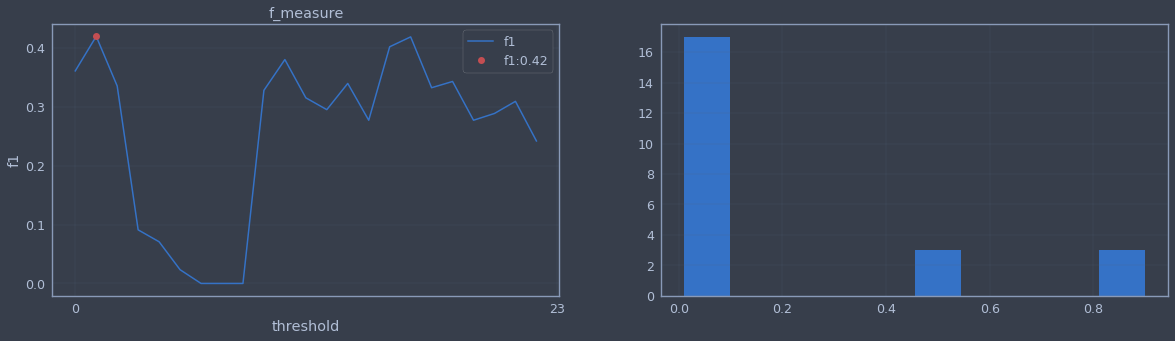

In [46]:
f1 = monitor_one(optimizer.results, "f_measure")

tested = list(optimizer.history.keys())
tested = [t[0] for t in tested]

best_combination = display_history(f1, tested, bins=10)

In [56]:
# Apply to eval
segments = encoder.encode(
    eval_strong_prediction,
    method="threshold",
    **best_parameters
)
to_evaluate = encoder.parse(segments, eval_filenames)
evaluator = eb_evaluator(eval_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 7543.56 sec
  Evaluated files                   : 880 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 37.15 %
    Precision                       : 37.00 %
    Recall                          : 37.29 %
  Error rate
    Error rate (ER)                 : 1.26 
    Substitution rate               : 0.01 
    Deletion rate                   : 0.62 
    Insertion rate                  : 0.63 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 39.22 %
    Precision                       : 37.35 %
    Recall                          : 43.91 %
  Error rate
    Error rate (ER)                 : 1.34 
    Deletion rate                   : 0.56 
    Insertion rate 

## Hysteresis

In [18]:
# Create the optimizer
optimizer = DichotomicOptimizer(
    {
        "low": (0.001, 0.9),
        "high": (0.001, 0.9),
        "smooth": "smoothMovingAvg",
        "window_len": (5, 27)
    },
    
    encoder = encoder,
#     step = 5,
    step = 2,
#     nb_recurse = 10,
    nb_recurse = 2,
    nb_process = 20
)

# Perform the optimization ON TEST
%time class_wise_results = class_wise_optimization(optimizer, class_list, method="hysteresis")

after :  {'low': (0.001, 0.9), 'high': (0.001, 0.002), 'smooth': 'smoothMovingAvg', 'window_len': (5, 10.0)}
after :  {'low': (0.45, 0.9), 'high': (0.001, 0.003), 'smooth': 'smoothMovingAvg', 'window_len': (5, 15.0)}
Alarm_bell_ringing {'low': 0.9, 'high': 0.002, 'smooth': 'smoothMovingAvg', 'window_len': 10.0} 0.3017241379310345


after :  {'low': (0.001, 0.9), 'high': (0.001, 0.002), 'smooth': 'smoothMovingAvg', 'window_len': (5, 10.0)}
after :  {'low': (0.45, 0.9), 'high': (0.001, 0.003), 'smooth': 'smoothMovingAvg', 'window_len': (5, 15.0)}
Speech {'low': 0.9, 'high': 0.002, 'smooth': 'smoothMovingAvg', 'window_len': 10.0} 0.07692307692307693


after :  {'low': (0.001, 0.9), 'high': (0.001, 0.002), 'smooth': 'smoothMovingAvg', 'window_len': (5, 10.0)}
after :  {'low': (0.001, 0.0015), 'high': (0.001, 0.003), 'smooth': 'smoothMovingAvg', 'window_len': (5, 15.0)}
Dog {'low': 0.001, 'high': 0.002, 'smooth': 'smoothMovingAvg', 'window_len': 10.0} 0.19704433497536947


after :  {'low': (0.001, 0.9), 'high': (0.001, 0.002), 'smooth': 'smoothMovingAvg', 'window_len': (5, 10.0)}
after :  {'low': (0.001, 0.0015), 'high': (0.001, 0.003), 'smooth': 'smoothMovingAvg', 'window_len': (5, 15.0)}
Cat {'low': 0.001, 'high': 0.002, 'smooth': 'smoothMovingAvg', 'window_len': 10.0} 0.34838709677419355


after :  {'low': (0.001, 0.9), 'high': (0.001, 0.002), 'smooth': 'smoothMovingAvg', 'window_len': (5, 27)}
after :  {'low': (0.001, 0.0015), 'high': (0.001, 0.003), 'smooth': 'smoothMovingAvg', 'window_len': (13.5, 27)}
Vacuum_cleaner {'low': 0.001, 'high': 0.002, 'smooth': 'smoothMovingAvg', 'window_len': 27.0} 0.7837837837837838


after :  {'low': (0.001, 0.9), 'high': (0.001, 0.002), 'smooth': 'smoothMovingAvg', 'window_len': (5, 10.0)}
after :  {'low': (0.45, 0.9), 'high': (0.001, 0.003), 'smooth': 'smoothMovingAvg', 'window_len': (5, 15.0)}
Dishes {'low': 0.9, 'high': 0.002, 'smooth': 'smoothMovingAvg', 'window_len': 10.0} 0.1036036036036036


after :  {'low': (0.001, 0.9), 'high': (0.001, 0.002), 'smooth': 'smoothMovingAvg', 'window_len': (5, 27)}
after :  {'low': (0.45, 0.9), 'high': (0.001, 0.0015), 'smooth': 'smoothMovingAvg', 'window_len': (13.5, 27)}
Frying {'low': 0.001, 'high': 0.002, 'smooth': 'smoothMovingAvg', 'window_len': 27.0} 0.7083333333333334


after :  {'low': (0.001, 0.9), 'high': (0.001, 0.002), 'smooth': 'smoothMovingAvg', 'window_len': (5, 27)}
after :  {'low': (0.45, 0.9), 'high': (0.001, 0.003), 'smooth': 'smoothMovingAvg', 'window_len': (13.5, 27)}
Electric_shaver_toothbrush {'low': 0.9, 'high': 0.002, 'smooth': 'smoothMovingAvg', 'window_len': 27.0} 0.5


after :  {'low': (0.001, 0.9), 'high': (0.001, 0.002), 'smooth': 'smoothMovingAvg', 'window_len': (5, 27)}
after :  {'low': (0.45, 0.9), 'high': (0.001, 0.003), 'smooth': 'smoothMovingAvg', 'window_len': (13.5, 27)}
Blender {'low': 0.9, 'high': 0.002, 'smooth': 'smoothMovingAvg', 'window_len': 27.0} 0.3695652173913044


after :  {'low': (0.001, 0.9), 'high': (0.001, 0.002), 'smooth': 'smoothMovingAvg', 'window_len': (5, 27)}
after :  {'low': (0.45, 0.9), 'high': (0.001, 0.003), 'smooth': 'smoothMovingAvg', 'window_len': (13.5, 27)}
Running_water {'low': 0.9, 'high': 0.002, 'smooth': 'smoothMovingAvg', 'window_len': 27.0} 0.19402985074626866
CPU times: user 1.77 s, sys: 1.67 s, total: 3.45 s
Wall time: 1min 37s


In [20]:
best_parameters = get_class_dependant_parameters(class_wise_results, class_list)
best_parameters

{'low': [0.9, 0.9, 0.001, 0.001, 0.001, 0.9, 0.001, 0.9, 0.9, 0.9],
 'high': [0.002,
  0.002,
  0.002,
  0.002,
  0.002,
  0.002,
  0.002,
  0.002,
  0.002,
  0.002],
 'smooth': 'smoothMovingAvg',
 'window_len': [10.0, 10.0, 10.0, 10.0, 27.0, 10.0, 27.0, 27.0, 27.0, 27.0]}

In [21]:
# detail test score
segments = encoder.encode(
    test_strong_prediction,
    method="hysteresis",
    **best_parameters
)
to_evaluate = encoder.parse(segments, test_filenames)
evaluator = eb_evaluator(test_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 2616.88 sec
  Evaluated files                   : 288 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 21.54 %
    Precision                       : 19.64 %
    Recall                          : 23.84 %
  Error rate
    Error rate (ER)                 : 1.72 
    Substitution rate               : 0.02 
    Deletion rate                   : 0.75 
    Insertion rate                  : 0.96 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 35.83 %
    Precision                       : 36.27 %
    Recall                          : 36.48 %
  Error rate
    Error rate (ER)                 : 1.41 
    Deletion rate                   : 0.64 
    Insertion rate 

8 0.3360880683155139


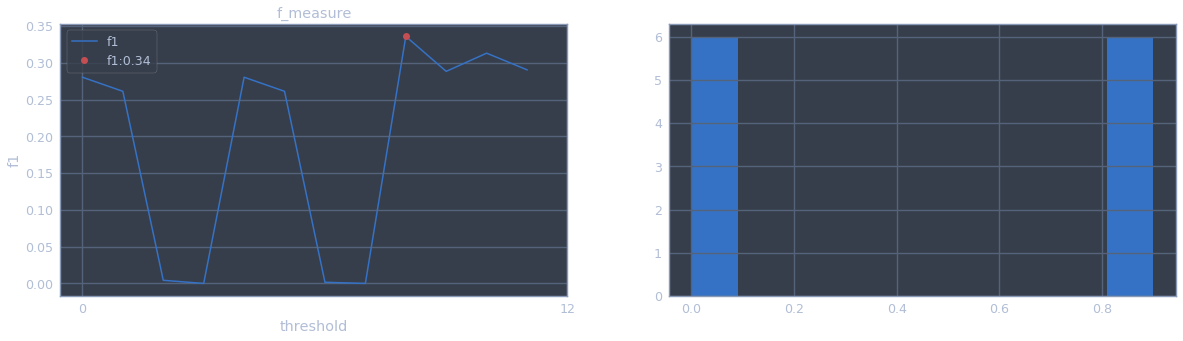

In [22]:
f1 = monitor_one(optimizer.results, "f_measure")

tested = list(optimizer.history.keys())
tested = [t[0] for t in tested]

best_combination = display_history(f1, tested, bins=10)

In [20]:
# Apply to eval
segments = encoder.encode(
    eval_strong_prediction,
    method="hysteresis",
    **best_parameters
)
to_evaluate = encoder.parse(segments, eval_filenames)
evaluator = eb_evaluator(eval_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 7543.56 sec
  Evaluated files                   : 880 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 20.27 %
    Precision                       : 19.33 %
    Recall                          : 21.31 %
  Error rate
    Error rate (ER)                 : 1.63 
    Substitution rate               : 0.04 
    Deletion rate                   : 0.75 
    Insertion rate                  : 0.85 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 24.36 %
    Precision                       : 22.80 %
    Recall                          : 27.68 %
  Error rate
    Error rate (ER)                 : 1.66 
    Deletion rate                   : 0.72 
    Insertion rate 

## Derivative

In [33]:
# Create the optimizer

optimizer = DichotomicOptimizer(
    {
        "rising" : (0.01, 0.99),
        "decreasing": (-0.01, -0.99),
        "high": (0.001, 0.9),
        "smooth": "smoothMovingAvg",
        "window_len": (3, 27),
        "window_size": (3, 27),
    },
    
    encoder = encoder,
    step = 2,
    nb_recurse = 2,
    nb_process = 20
)

%time class_wise_results = class_wise_optimization(optimizer, class_list, method="derivative")

after :  {'rising': (0.01, 0.02), 'decreasing': (0.0, -0.99), 'high': (0.001, 0.9), 'smooth': 'smoothMovingAvg', 'window_len': (3, 6.0), 'window_size': (3, 6.0)}
after :  {'rising': (0.01, 0.03), 'decreasing': (0.0, -0.99), 'high': (0.45, 0.9), 'smooth': 'smoothMovingAvg', 'window_len': (3, 9.0), 'window_size': (3, 9.0)}
Alarm_bell_ringing {'rising': 0.02, 'decreasing': 0.0, 'high': 0.9, 'smooth': 'smoothMovingAvg', 'window_len': 6.0, 'window_size': 6.0} 0.24451410658307204


after :  {'rising': (0.01, 0.02), 'decreasing': (0.0, -0.99), 'high': (0.001, 0.9), 'smooth': 'smoothMovingAvg', 'window_len': (3, 27), 'window_size': (3, 27)}
after :  {'rising': (0.01, 0.03), 'decreasing': (0.0, -0.99), 'high': (0.001, 0.0015), 'smooth': 'smoothMovingAvg', 'window_len': (3, 4.5), 'window_size': (3, 4.5)}
Speech {'rising': 0.01, 'decreasing': -0.01, 'high': 0.9, 'smooth': 'smoothMovingAvg', 'window_len': 27.0, 'window_size': 27.0} 0.07575757575757575


after :  {'rising': (0.01, 0.02), 'decreasing': (0.0, -0.99), 'high': (0.001, 0.9), 'smooth': 'smoothMovingAvg', 'window_len': (3, 6.0), 'window_size': (3, 6.0)}
after :  {'rising': (0.01, 0.03), 'decreasing': (0.0, -0.99), 'high': (0.45, 0.9), 'smooth': 'smoothMovingAvg', 'window_len': (3, 9.0), 'window_size': (3, 4.5)}
Dog {'rising': 0.02, 'decreasing': 0.0, 'high': 0.9, 'smooth': 'smoothMovingAvg', 'window_len': 6.0, 'window_size': 3.0} 0.22142857142857142


after :  {'rising': (0.01, 0.02), 'decreasing': (0.0, -0.99), 'high': (0.001, 0.9), 'smooth': 'smoothMovingAvg', 'window_len': (3, 27), 'window_size': (3, 6.0)}
after :  {'rising': (0.01, 0.03), 'decreasing': (0.0, -0.99), 'high': (0.001, 0.0015), 'smooth': 'smoothMovingAvg', 'window_len': (3, 4.5), 'window_size': (3, 9.0)}
Cat {'rising': 0.01, 'decreasing': -0.01, 'high': 0.9, 'smooth': 'smoothMovingAvg', 'window_len': 27.0, 'window_size': 3.0} 0.27118644067796616


after :  {'rising': (0.01, 0.99), 'decreasing': (0.0, -1.98), 'high': (0.001, 0.002), 'smooth': 'smoothMovingAvg', 'window_len': (3, 27), 'window_size': (3, 27)}
after :  {'rising': (0.495, 0.99), 'decreasing': (-0.01, -2.9699999999999998), 'high': (0.001, 0.003), 'smooth': 'smoothMovingAvg', 'window_len': (13.5, 27), 'window_size': (3, 4.5)}
Vacuum_cleaner {'rising': 0.99, 'decreasing': -1.98, 'high': 0.002, 'smooth': 'smoothMovingAvg', 'window_len': 27.0, 'window_size': 3.0} 0.7999999999999999


after :  {'rising': (0.01, 0.02), 'decreasing': (0.0, -0.99), 'high': (0.001, 0.9), 'smooth': 'smoothMovingAvg', 'window_len': (3, 6.0), 'window_size': (3, 6.0)}
after :  {'rising': (0.01, 0.015), 'decreasing': (0.0, -0.99), 'high': (0.45, 0.9), 'smooth': 'smoothMovingAvg', 'window_len': (3, 4.5), 'window_size': (3, 4.5)}
Dishes {'rising': 0.01, 'decreasing': -0.01, 'high': 0.9, 'smooth': 'smoothMovingAvg', 'window_len': 3.0, 'window_size': 3.0} 0.1267605633802817


after :  {'rising': (0.01, 0.99), 'decreasing': (0.0, -1.98), 'high': (0.001, 0.002), 'smooth': 'smoothMovingAvg', 'window_len': (3, 27), 'window_size': (3, 27)}
after :  {'rising': (0.495, 0.99), 'decreasing': (-0.01, -2.9699999999999998), 'high': (0.001, 0.003), 'smooth': 'smoothMovingAvg', 'window_len': (13.5, 27), 'window_size': (13.5, 27)}
Frying {'rising': 0.99, 'decreasing': -1.98, 'high': 0.002, 'smooth': 'smoothMovingAvg', 'window_len': 27.0, 'window_size': 27.0} 0.7083333333333334


after :  {'rising': (0.01, 0.99), 'decreasing': (0.0, -1.98), 'high': (0.001, 0.002), 'smooth': 'smoothMovingAvg', 'window_len': (3, 27), 'window_size': (3, 27)}
after :  {'rising': (0.495, 0.99), 'decreasing': (-0.01, -2.9699999999999998), 'high': (0.001, 0.003), 'smooth': 'smoothMovingAvg', 'window_len': (13.5, 27), 'window_size': (13.5, 27)}
Electric_shaver_toothbrush {'rising': 0.99, 'decreasing': -1.98, 'high': 0.002, 'smooth': 'smoothMovingAvg', 'window_len': 27.0, 'window_size': 27.0} 0.5


after :  {'rising': (0.01, 0.99), 'decreasing': (0.0, -1.98), 'high': (0.001, 0.002), 'smooth': 'smoothMovingAvg', 'window_len': (3, 27), 'window_size': (3, 27)}
after :  {'rising': (0.495, 0.99), 'decreasing': (0.0, -0.99), 'high': (0.001, 0.003), 'smooth': 'smoothMovingAvg', 'window_len': (13.5, 27), 'window_size': (3, 4.5)}
Blender {'rising': 0.99, 'decreasing': 0.0, 'high': 0.002, 'smooth': 'smoothMovingAvg', 'window_len': 27.0, 'window_size': 3.0} 0.39560439560439564


after :  {'rising': (0.01, 0.02), 'decreasing': (0.0, -1.98), 'high': (0.001, 0.9), 'smooth': 'smoothMovingAvg', 'window_len': (3, 6.0), 'window_size': (3, 6.0)}
after :  {'rising': (0.01, 0.015), 'decreasing': (-0.01, -2.9699999999999998), 'high': (0.45, 0.9), 'smooth': 'smoothMovingAvg', 'window_len': (3, 4.5), 'window_size': (3, 9.0)}
Running_water {'rising': 0.01, 'decreasing': -1.98, 'high': 0.9, 'smooth': 'smoothMovingAvg', 'window_len': 3.0, 'window_size': 6.0} 0.22727272727272727
CPU times: user 7.51 s, sys: 7.49 s, total: 15 s
Wall time: 7min 2s


In [34]:
best_parameters = get_class_dependant_parameters(class_wise_results, class_list)
best_parameters

{'rising': [0.02, 0.01, 0.02, 0.01, 0.99, 0.01, 0.99, 0.99, 0.99, 0.01],
 'decreasing': [0.0,
  -0.01,
  0.0,
  -0.01,
  -1.98,
  -0.01,
  -1.98,
  -1.98,
  0.0,
  -1.98],
 'high': [0.9, 0.9, 0.9, 0.9, 0.002, 0.9, 0.002, 0.002, 0.002, 0.9],
 'smooth': 'smoothMovingAvg',
 'window_len': [6.0, 27.0, 6.0, 27.0, 27.0, 3.0, 27.0, 27.0, 27.0, 3.0],
 'window_size': [6.0, 27.0, 3.0, 3.0, 3.0, 3.0, 27.0, 27.0, 3.0, 6.0]}

In [35]:
# detail test score
segments = encoder.encode(
    test_strong_prediction,
    method="derivative",
    **best_parameters
)
to_evaluate = encoder.parse(segments, test_filenames)
evaluator = eb_evaluator(test_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 2616.88 sec
  Evaluated files                   : 288 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 23.46 %
    Precision                       : 23.76 %
    Recall                          : 23.18 %
  Error rate
    Error rate (ER)                 : 1.51 
    Substitution rate               : 0.00 
    Deletion rate                   : 0.76 
    Insertion rate                  : 0.74 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 35.71 %
    Precision                       : 37.50 %
    Recall                          : 35.92 %
  Error rate
    Error rate (ER)                 : 1.30 
    Deletion rate                   : 0.64 
    Insertion rate 

34 0.2978547200993754


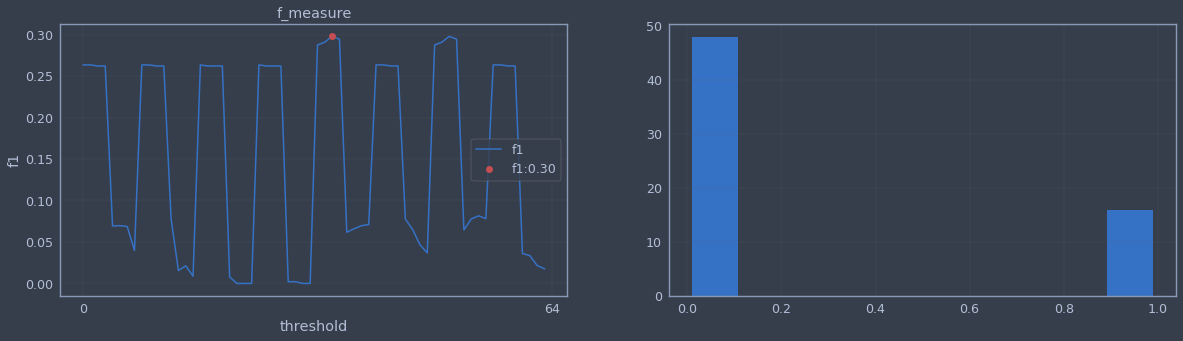

In [36]:
f1 = monitor_one(optimizer.results, "f_measure")

tested = list(optimizer.history.keys())
tested = [t[0] for t in tested]

best_combination = display_history(f1, tested, bins=10)

In [40]:
# Apply to eval
segments = encoder.encode(
    eval_strong_prediction,
    method="hysteresis",
    **parameters
)
to_evaluate = encoder.parse(segments, eval_filenames)
evaluator = eb_evaluator(eval_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 7543.56 sec
  Evaluated files                   : 880 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 16.39 %
    Precision                       : 16.00 %
    Recall                          : 16.82 %
  Error rate
    Error rate (ER)                 : 1.67 
    Substitution rate               : 0.05 
    Deletion rate                   : 0.79 
    Insertion rate                  : 0.84 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 23.93 %
    Precision                       : 23.55 %
    Recall                          : 25.86 %
  Error rate
    Error rate (ER)                 : 1.63 
    Deletion rate                   : 0.74 
    Insertion rate 